### Import all Libraries

In [1]:
import os
import warnings
import sys
import regex as re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,)
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import mlflow.sklearn
import logging
from pprint import pprint
from pathlib import Path
import dvc.api

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [2]:
warnings.filterwarnings('ignore')
np.random.seed(40)

### Get the particular Data version using DVC API

In [3]:
path = 'data\processed\data.csv'
repo = Path(os.getcwd()).parent.parent
version = "v1"

In [4]:
data_url = dvc.api.get_url(path=path,repo=repo,rev=version)
print(data_url)

gdrive://1NiqgvY7qLsxbxYiDS2BUWGpnLzejg6px/ab/2639b2cd4b42bd8ec26bb333023f80


In [5]:
with dvc.api.open(path=path,repo=repo,rev=version) as f:
    data = pd.read_csv(f)

In [6]:
data.head()

,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours,target
0,1.000000,0.0,3.000000,0.0,5.0,21.0,3.008503,4.070495,0.0,0.920,36.0,1.0
1,1.000000,1.0,3.000000,0.0,5.0,6.0,4.000000,5.000000,4.0,0.776,47.0,0.0
2,0.953038,1.0,0.000000,0.0,5.0,15.0,3.036662,4.713792,6.0,0.624,83.0,0.0
3,0.940145,1.0,1.907067,0.0,1.0,20.0,2.923227,5.000000,6.0,0.789,52.0,1.0
4,1.000000,0.0,3.000000,2.0,5.0,21.0,4.000000,1.000000,3.0,0.767,8.0,0.0


In [7]:
data.shape

(19158, 12)

In [8]:
X = data.drop(['target'], axis=1)
y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=2)

In [9]:
#Function for getting Autolog tracked data
'''
Function for Getting all the logged data information by mlflow.
'''
def fetch_logged_data(run_id):
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

### Autolog Data

In [10]:
mlflow.get_tracking_uri()


'file:///C:/Users/aniket.itankar/Desktop/HR_Analytics/notebooks/mlflow/mlruns'

In [11]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

### RandomForest Classifier

In [12]:
n_estimators=150
criterion="gini"
max_depth=10
rf = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion,max_depth=max_depth)

with mlflow.start_run() as run:

    # Since DVC uri won't be autologged so logging seperately

    mlflow.log_param("Data Url",data_url)


    mlflow.sklearn.autolog(log_models=True)

    rf.fit(X_train,Y_train) # logging performance about train dataset
    
    mlflow.sklearn.eval_and_log_metrics(rf,X_test,Y_test,prefix="eval_") # logging performance about evaluation dataset

    params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)
    
    print(metrics)

    print(params)
    print("completed tracking")


{'training_precision_score': 0.9359297245845839, 'training_recall_score': 0.9364478663708731, 'training_f1_score': 0.9350440252611042, 'training_accuracy_score': 0.9364478663708731, 'training_log_loss': 0.2015634666572063, 'training_roc_auc_score': 0.9678648196388857, 'training_score': 0.9364478663708731, 'eval_precision_score': 0.9128828465728224, 'eval_recall_score': 0.9144050104384134, 'eval_f1_score': 0.9124775733618679, 'eval_accuracy_score': 0.9144050104384134, 'eval_log_loss': 0.23741825298711966, 'eval_roc_auc_score': 0.9385454825604612, 'eval_score': 0.9144050104384134}
{'Data Url': 'gdrive://1NiqgvY7qLsxbxYiDS2BUWGpnLzejg6px/ab/2639b2cd4b42bd8ec26bb333023f80', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'max_depth': '10', 'max_features': 'auto', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '150', 'n

In [13]:
print(artifacts)

['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/requirements.txt']


### Model reistry and version tracking

In [14]:
mlflow.get_tracking_uri()

'sqlite:///mlruns.db'

### Load versions of the registered model

In [15]:
#Load versions of the registered model
import mlflow.pyfunc
model_name = "HR_Analytics_All_Model"

model_version_uri = "models:/{model_name}/1".format(model_name=model_name)
print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_version_uri))
model_version_1 = mlflow.pyfunc.load_model(model_version_uri)

Loading registered model version from URI: 'models:/HR_Analytics_All_Model/1'


### Generate predictions with the Version 1 model

In [16]:
#Generate predictions with the Version 1 model
results = model_version_1.predict(pd.DataFrame(X_test))
accuracy  = accuracy_score(Y_test,results)
print("Accuracy Obtained in production:",accuracy
)


Accuracy Obtained in production: 0.9144050104384134


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

### KNN Classifier

In [18]:
#KNN Classifier
knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, param_grid=knn_param_grid, cv = StratifiedKFold(n_splits = 10), 
                   scoring = "accuracy", n_jobs = -1,verbose = 1)

with mlflow.start_run() as run:

    # Since DVC uri won't be autologged so logging seperately

    mlflow.log_param("Data Url",data_url)


    mlflow.sklearn.autolog(log_models=True)

    clf.fit(X_train,Y_train) # logging performance about train dataset
    
    mlflow.sklearn.eval_and_log_metrics(rf,X_test,Y_test,prefix="eval_") # logging performance about evaluation dataset

    params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)
    
    print(metrics)

    print(params)
    print("completed tracking")

Fitting 10 folds for each of 40 candidates, totalling 400 fits


2022/06/14 22:08:46 INFO mlflow.sklearn.utils: Logging the 5 best runs, 35 runs will be omitted.


{'training_precision_score': 0.7511409060041608, 'training_recall_score': 0.7714994127626256, 'training_f1_score': 0.7141720517998482, 'training_accuracy_score': 0.7714994127626256, 'training_log_loss': 0.4840816276074577, 'training_roc_auc_score': 0.7530028028612634, 'training_score': 0.7714994127626256, 'best_cv_score': 0.7544688310604473, 'eval_precision_score': 0.9128828465728224, 'eval_recall_score': 0.9144050104384134, 'eval_f1_score': 0.9124775733618679, 'eval_accuracy_score': 0.9144050104384134, 'eval_log_loss': 0.23741825298711966, 'eval_roc_auc_score': 0.9385454825604612, 'eval_score': 0.9144050104384134}
{'Data Url': 'gdrive://1NiqgvY7qLsxbxYiDS2BUWGpnLzejg6px/ab/2639b2cd4b42bd8ec26bb333023f80', 'cv': 'StratifiedKFold(n_splits=10, random_state=None, shuffle=False)', 'error_score': 'nan', 'estimator': 'KNeighborsClassifier()', 'n_jobs': '-1', 'param_grid': "{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhat

In [19]:
print(artifacts)

['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/requirements.txt']


### Create version 2 of register model

In [21]:
model_name = "HR_Analytics_All_Model"
model_version_uri = "models:/{model_name}/2".format(model_name=model_name)
print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_version_uri))
model_version_2 = mlflow.pyfunc.load_model(model_version_uri)

Loading registered model version from URI: 'models:/HR_Analytics_All_Model/2'


### Generate predictions with the Version 2 model

In [22]:
#Generate predictions with the Version 2 model
results = model_version_2.predict(pd.DataFrame(X_test))
accuracy  = accuracy_score(Y_test,results)
print("Accuracy Obtained in production:",accuracy
)

Accuracy Obtained in production: 0.7486951983298539


### Use XGBoost to create and register the second model

In [23]:
from xgboost import XGBClassifier

In [24]:
n_estimators = 10
max_depth = 5
learning_rate = 0.2
colsample_bytree = 0.8
gamma = 10

xgb = XGBClassifier(n_estimators=n_estimators,max_depth=max_depth,
learning_rate=learning_rate,colsample_bytree=colsample_bytree,gamma=gamma)

In [25]:
def eval_metrics(actual, pred):
    accuracy  = accuracy_score(actual,pred)
    precision = precision_score(actual,pred)
    recall = recall_score(actual,pred)
    f1 = f1_score(actual,pred)
    roc = roc_auc_score(actual,pred)
    return accuracy,precision,recall,f1,roc

### Mlflow manual logging and version updation

In [ ]:
with mlflow.start_run() as run2:
    xgb.fit(X_train,Y_train)
    predicted_quantities = xgb.predict(X_test)

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("learning rate", max_depth)
    mlflow.log_param("colsample_bytree",colsample_bytree)
    mlflow.log_param("Gamma",gamma)

    (accuracy,precision,recall,f1,roc) = eval_metrics(Y_test,predicted_quantities)

    mlflow.log_metric("Accuracy",accuracy)
    mlflow.log_metric("Precision",precision)
    mlflow.log_metric("Recall",recall)
    mlflow.log_metric("F1 score",f1)
    mlflow.log_metric("AUC score",roc)

    clsf_report = pd.DataFrame(classification_report(Y_test, predicted_quantities, output_dict=True)).transpose()
    clsf_report.to_csv(r'visualization\classification_report.csv', index=True)
    mlflow.log_artifact(r'visualization\classification_report.csv')

    confusion_matrix = pd.crosstab(Y_test, predicted_quantities, rownames=['label'], colnames=['prediction'])
    plt.figure(figsize=(6,5))

    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='d')
    plt.savefig(r"visualization\confusion_matrix.png")
    mlflow.log_artifact(r"visualization\confusion_matrix.png") 

    client = mlflow.tracking.MlflowClient()
    run_id = mlflow.active_run().info.run_id

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    print(tracking_url_type_store)
    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(xgb, "model", registered_model_name="HR_Analytics_All_Model")
        print("completed")
    else:
        mlflow.sklearn.log_model(xgb)   

In [27]:
from mlflow.tracking.client import MlflowClient
model_version = 3
client = MlflowClient()
client.update_model_version(
  name=model_name,
  version=model_version,
  description="This is the best model version. It's a xboost model"
)

<ModelVersion: creation_timestamp=1655224836602, current_stage='None', description="This is the best model version. It's a xboost model", last_updated_timestamp=1655224858574, name='HR_Analytics_All_Model', run_id='a41ec1d2c264457da8a5b0dd11996051', run_link=None, source='./mlruns/0/a41ec1d2c264457da8a5b0dd11996051/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [28]:
model_name = "HR_Analytics_All_Model"
model_version = 3
model_version_uri = "models:/{model_name}/3".format(model_name=model_name)
print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_version_uri))
model_version_3 = mlflow.pyfunc.load_model(model_version_uri)

Loading registered model version from URI: 'models:/HR_Analytics_All_Model/3'


In [29]:
results = model_version_3.predict(pd.DataFrame(X_test))
accuracy  = accuracy_score(Y_test,results)
print("Accuracy Obtained in production:",accuracy
)

Accuracy Obtained in production: 0.9144050104384134


### Model Explainability using SHAP

In [30]:
import shap

In [35]:
explainer = shap.TreeExplainer(xgb)


In [36]:
shap_values = explainer.shap_values(X_test)

In [39]:
shap.initjs()

In [40]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

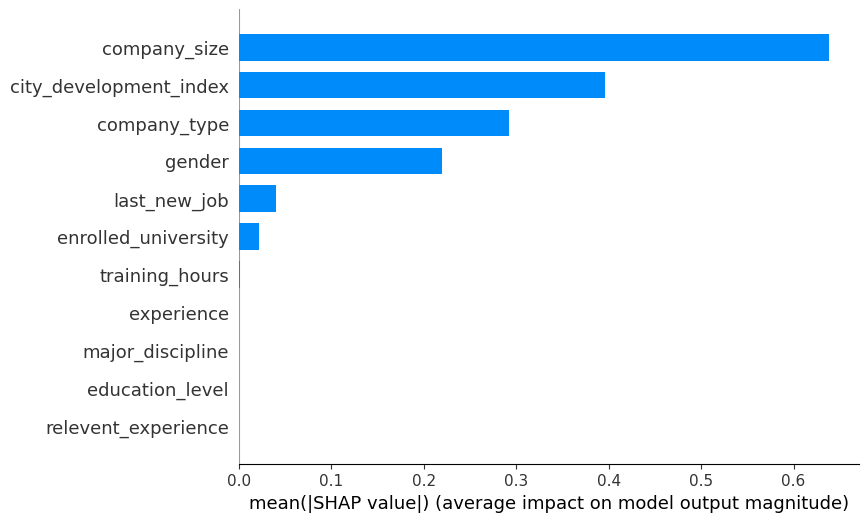

In [42]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

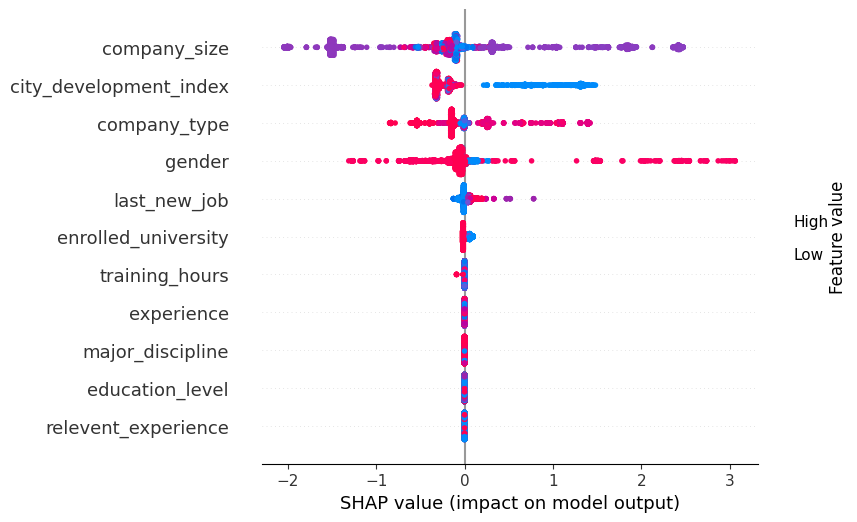

In [46]:
shap.summary_plot(shap_values, X_test)

In [74]:
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X)

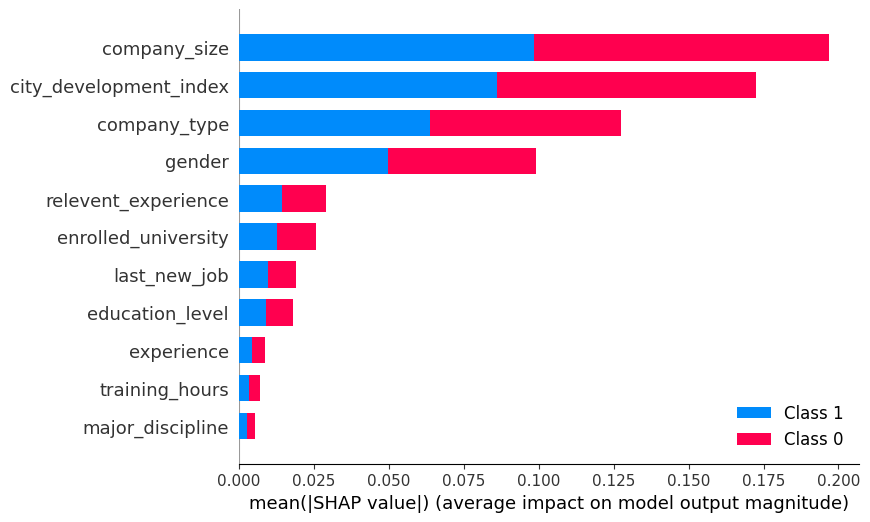

In [75]:
#The features are ordered by how much they influenced the model’s prediction. 
# The x-axis stands for the average of the absolute SHAP value of each feature.
shap.summary_plot(shap_values_rf, X, plot_type="bar")

In [76]:
#Positive SHAP value means positive impact on prediction, leading the model to predict 1. 
# Negative SHAP value means negative impact, leading the model to predict 0.
pd.DataFrame(shap_values_rf[0])

,0,1,2,3,4,5,6,7,8,9,10
0,0.001275,0.012094,0.009551,-0.013154,-0.001699,0.001667,-0.340161,-0.343330,-0.024391,0.030160,-0.000314
1,0.021030,-0.025275,0.007419,-0.012782,-0.000462,-0.003575,0.054528,0.033514,0.002001,0.045725,0.000853
2,0.064261,-0.009802,-0.008552,-0.007034,-0.001256,0.000639,0.278293,0.016522,0.015375,-0.115427,0.003106
3,-0.010960,-0.056989,-0.096166,-0.012043,0.002929,-0.008625,-0.238812,0.080932,-0.076622,0.010793,-0.009682
4,0.022192,0.009054,0.010243,0.008697,-0.001005,0.012119,0.067568,0.009398,-0.005556,0.053550,-0.005331
...,...,...,...,...,...,...,...,...,...,...,...
19153,0.003646,-0.031353,0.011199,-0.021758,-0.008843,0.000476,-0.311065,-0.319746,-0.020214,0.026196,-0.001273
19154,0.007444,0.015881,0.006047,-0.012402,-0.000992,0.000556,-0.365595,-0.284789,-0.017713,0.032949,-0.000933
19155,0.020220,0.006913,0.007942,-0.005052,-0.001143,0.010670,0.042507,0.033885,-0.003486,0.063833,-0.001202
19156,0.021393,0.004847,0.007599,0.017467,0.012234,-0.003266,0.041352,0.029692,-0.000279,0.053439,0.004902


In [57]:
X_test.shape

(3832, 11)

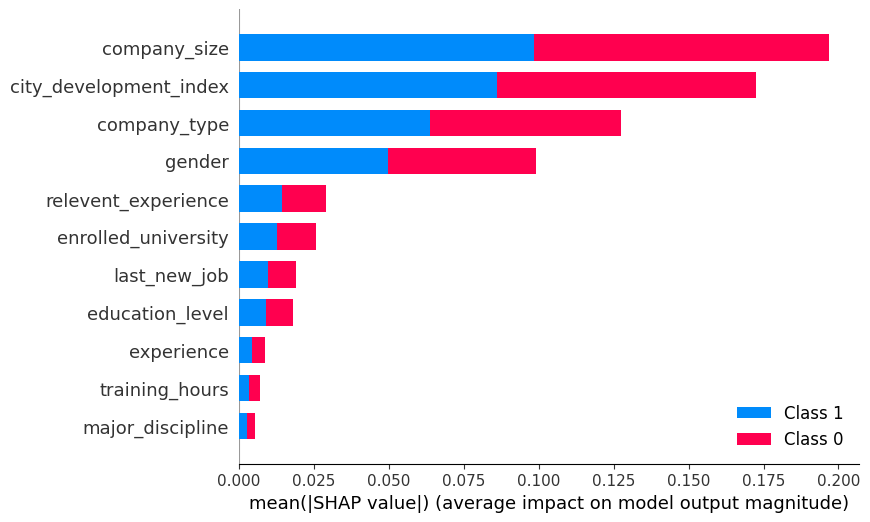

In [77]:
shap.summary_plot(shap_values_rf,X)